# Scanpy: Differential expression

Once we have done clustering, let's compute a ranking for the highly differential genes in each cluster. 


Differential expression is performed with the function `rank_genes_group`.  The default method to compute differential expression is the `t-test_overestim_var`. Other implemented methods are: `logreg`, `t-test` and `wilcoxon`.

By default, the .raw attribute of AnnData is used in case it has been initialized, it can be changed by setting `use_raw=False`. 

The clustering with resolution 0.6 seems to give a reasonable number of clusters, so we will use that clustering for all DE tests.

First, let's import libraries and fetch the clustered data from the previous lab.

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import gseapy
import matplotlib.pyplot as plt

sc.settings.verbosity = 2             # verbosity: errors (0), warnings (1), info (2), hints (3)
#sc.logging.print_versions()


In [2]:
sc.settings.set_figure_params(dpi=80)

Read in the clustered data object.

In [4]:
import os
ff=[f for f in os.listdir() if f.endswith('.h5ad')]
dd = [sc.read_h5ad(f) for f in ff]

## Gene Set Analysis
***

Hypergeometric enrichment test

Having a defined list of differentially expressed genes, you can now look for their combined function using hypergeometric test:


In [6]:
#Available databases : ‘Human’, ‘Mouse’, ‘Yeast’, ‘Fly’, ‘Fish’, ‘Worm’ 
gene_set_names = gseapy.get_library_name(database='Human')


In [20]:
for d in dd:
    sc.tl.rank_genes_groups(d, 'leiden', method='wilcoxon', key_added = "wilcoxon")

ranking genes
    finished (0:00:13)
ranking genes
    finished (0:00:12)
ranking genes
    finished (0:00:17)
ranking genes
    finished (0:00:51)
ranking genes
    finished (0:00:14)
ranking genes
    finished (0:00:18)
ranking genes
    finished (0:00:10)
ranking genes
    finished (0:00:10)
ranking genes
    finished (0:00:16)
ranking genes
    finished (0:00:09)
ranking genes
    finished (0:00:20)
ranking genes
    finished (0:00:24)
ranking genes
    finished (0:00:15)


In [37]:
#?gseapy.enrichr
for j in range(0,len(ff)):
    glist = [sc.get.rank_genes_groups_df(dd[j], group=i, key="wilcoxon").head(200).names.tolist() for i in dd[j].obs.leiden.cat.categories]
    for i in range(0,len(glist)):
        enr_res = gseapy.enrichr(gene_list=glist[i],
                         organism='Human',
                         gene_sets='KEGG_2019_Human',
                         description='pathway',
                         cutoff = 0.5)
        enr_res.results.to_csv('KEGG/'+os.path.splitext(ff[j])[0]+'_'+str(i)+'.csv', sep='\t', header=True, index=False)

2021-03-24 16:34:29,117 Warning: No enrich terms using library KEGG_2019_Human when cutoff = 0.5
2021-03-24 16:41:55,198 Warning: No enrich terms using library KEGG_2019_Human when cutoff = 0.5
2021-03-24 16:44:04,570 Warning: No enrich terms using library KEGG_2019_Human when cutoff = 0.5
2021-03-24 16:44:13,981 Warning: No enrich terms using library KEGG_2019_Human when cutoff = 0.5


In [30]:
d

AnnData object with n_obs × n_vars = 4210 × 6990
    obs: 'CellID', 'CellType', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'new_clusters'
    var: 'Gene', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'hvg', 'leiden', 'leiden_colors', 'neighbors', 'new_clusters_colors', 'pca', 'rank_genes_groups', 'umap', 'wilcoxon'
    obsm: 'X_pca', 'X_umap', 'spatial'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [27]:
cl1.raw.X.shape


(998, 18752)

In [28]:
# filter for genes that are expressed in more than 5 cells
tmp = cl1.raw.to_adata() 
sc.pp.calculate_qc_metrics(tmp, percent_top=None, log1p=False, inplace=True)
tmp = tmp[:,tmp.var['n_cells_by_counts']>5]


In [29]:
sc.tl.rank_genes_groups(tmp, 'type', method='wilcoxon', key_added = "wilcoxon")


sc.get.rank_genes_groups_df(tmp, group='Covid', key='wilcoxon')

ranking genes


Trying to set attribute `.uns` of view, copying.


    finished (0:00:00)


,scores,names,logfoldchanges,pvals,pvals_adj
0,15.033703,RPS4Y1,33.603333,4.416126e-51,2.566432e-47
1,11.229327,S100A9,3.316535,2.926985e-29,4.252543e-26
2,10.765179,ISG15,4.574336,5.026409e-27,6.491328e-24
3,9.983373,IGKC,3.866964,1.802345e-23,1.232274e-20
4,9.738068,NFKBIA,7.149486,2.074624e-22,1.269124e-19
...,...,...,...,...,...
11618,-12.137004,RPS3A,-13.038676,6.724322e-34,1.302613e-30
11619,-12.317586,EEF1A1,-32.098255,7.284229e-35,1.693292e-31
11620,-12.494949,RPS26,-8.365871,7.954684e-36,2.311432e-32
11621,-14.077871,RPS4X,-17.972118,5.195135e-45,2.012769e-41


In [30]:
glist = sc.get.rank_genes_groups_df(tmp, group='Covid', key='wilcoxon')['names'].squeeze().str.strip().tolist()
print(len(glist))

11623


In [31]:
enr_res = gseapy.enrichr(gene_list=glist,
                     organism='Human',
                     gene_sets='GO_Biological_Process_2018',
                     description='pathway',
                     cutoff = 0.5)

In [32]:
enr_res.results.head()

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,GO_Biological_Process_2018,gene expression (GO:0010467),374/411,8.705158e-51,4.389141e-47,0,0,7.494144,863.834378,RPL4;RPL5;ISCA2;RPL30;RPL3;NUP107;RPL32;RPL31;...
1,GO_Biological_Process_2018,mRNA processing (GO:0006397),269/283,1.209865e-46,3.050070e-43,0,0,14.152640,1496.336032,CCNH;EIF4A3;HNRNPU;GPATCH1;WDR83;HNRNPR;CCAR1;...
2,GO_Biological_Process_2018,"mRNA splicing, via spliceosome (GO:0000398)",250/261,2.476775e-45,4.162633e-42,0,0,16.718224,1717.118305,EIF4A3;HNRNPU;GPATCH1;WDR83;HNRNPR;CCAR1;PNN;S...
3,GO_Biological_Process_2018,"RNA splicing, via transesterification reaction...",229/236,7.638482e-45,9.628307e-42,0,0,24.031821,2441.227630,EIF4A3;HNRNPU;GPATCH1;WDR83;HNRNPR;CCAR1;PNN;S...
4,GO_Biological_Process_2018,ribosome biogenesis (GO:0042254),216/226,8.047261e-39,8.114858e-36,0,0,15.843535,1389.723356,LTV1;RPL4;RPL5;RPL30;RPL3;RPL32;RPL31;RPL34;PO...



Some databases of interest:

* `GO_Biological_Process_2017b`
* `KEGG_2019_Human`
* `KEGG_2019_Mouse`
* `WikiPathways_2019_Human`
* `WikiPathways_2019_Mouse`

You visualize your results using a simple barplot, for example:


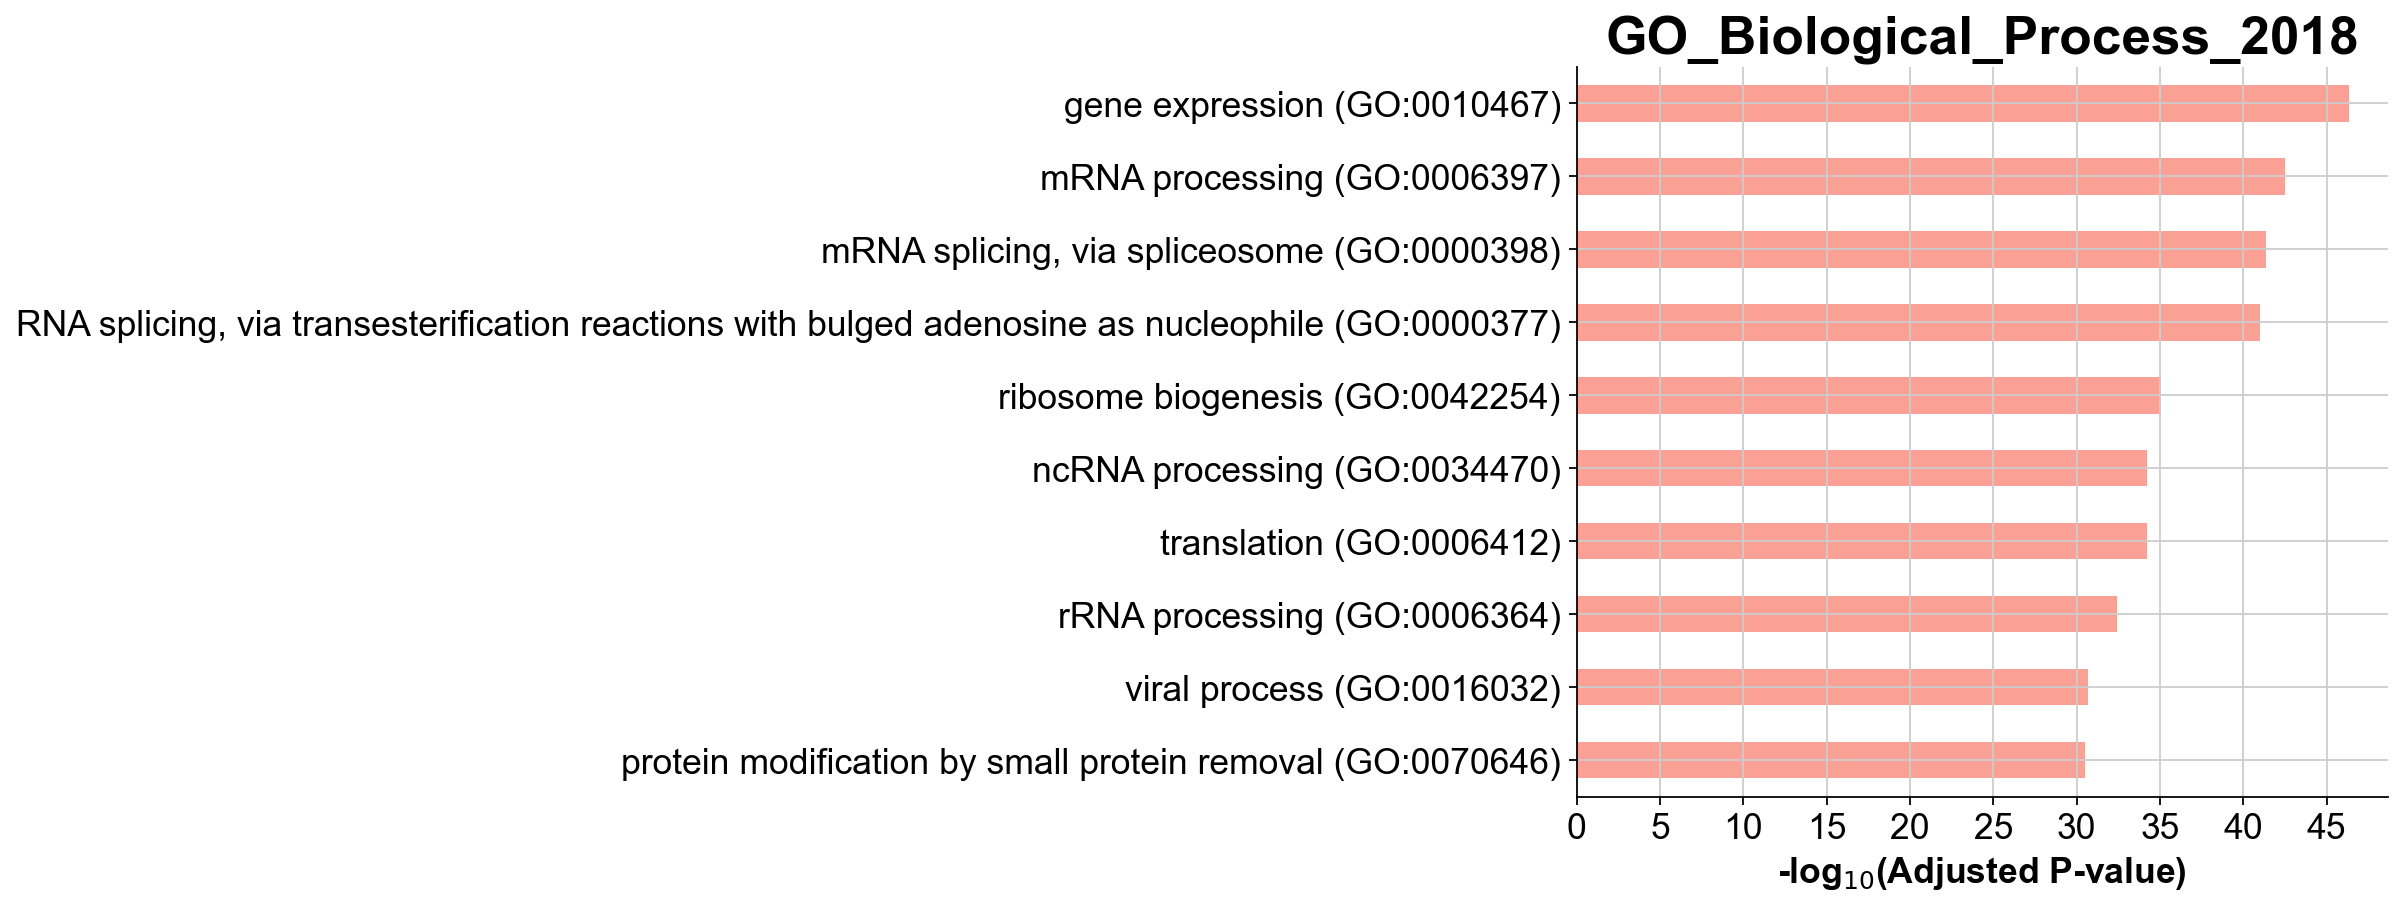

In [33]:
gseapy.barplot(enr_res.res2d,title='GO_Biological_Process_2018')

Gene Set Enrichment Analysis (GSEA)

Besides the enrichment using hypergeometric test, we can also perform gene set enrichment analysis (GSEA), which scores ranked genes list (usually based on fold changes) and computes permutation test to check if a particular gene set is more present in the Up-regulated genes, amongthe DOWN_regulated genes or not differentially regulated.


In [34]:
gene_rank = sc.tl.rank_genes_groups(cl1, 'type', method='wilcoxon', key_added = "wilcoxon",n_genes=cl1.shape[0])
gene_rank1 = sc.get.rank_genes_groups_df(cl1, group='Covid', key='wilcoxon')[['names','logfoldchanges']]
gene_rank2 = sc.get.rank_genes_groups_df(cl1, group='Ctrl', key='wilcoxon')[['names','logfoldchanges']]

ranking genes
    finished (0:00:01)


In [35]:
gene_rank2['logfoldchanges'] = -gene_rank2['logfoldchanges']
gene_rank2
gene_rank = gene_rank1.append( gene_rank2 )

 Once our list of genes are sorted, we can proceed with the enrichment itself. We can use the package to get gene set from the Molecular Signature Database (MSigDB) and select KEGG pathways as an example.


In [36]:
#Available databases : ‘Human’, ‘Mouse’, ‘Yeast’, ‘Fly’, ‘Fish’, ‘Worm’ 
gene_set_names = gseapy.get_library_name(database='Human')
print(gene_set_names)

['ARCHS4_Cell-lines', 'ARCHS4_IDG_Coexp', 'ARCHS4_Kinases_Coexp', 'ARCHS4_TFs_Coexp', 'ARCHS4_Tissues', 'Achilles_fitness_decrease', 'Achilles_fitness_increase', 'Aging_Perturbations_from_GEO_down', 'Aging_Perturbations_from_GEO_up', 'Allen_Brain_Atlas_10x_scRNA_2021', 'Allen_Brain_Atlas_down', 'Allen_Brain_Atlas_up', 'BioCarta_2013', 'BioCarta_2015', 'BioCarta_2016', 'BioPlanet_2019', 'BioPlex_2017', 'CCLE_Proteomics_2020', 'CORUM', 'COVID-19_Related_Gene_Sets', 'Cancer_Cell_Line_Encyclopedia', 'ChEA_2013', 'ChEA_2015', 'ChEA_2016', 'Chromosome_Location', 'Chromosome_Location_hg19', 'ClinVar_2019', 'DSigDB', 'Data_Acquisition_Method_Most_Popular_Genes', 'DepMap_WG_CRISPR_Screens_Broad_CellLines_2019', 'DepMap_WG_CRISPR_Screens_Sanger_CellLines_2019', 'DisGeNET', 'Disease_Perturbations_from_GEO_down', 'Disease_Perturbations_from_GEO_up', 'Disease_Signatures_from_GEO_down_2014', 'Disease_Signatures_from_GEO_up_2014', 'DrugMatrix', 'Drug_Perturbations_from_GEO_2014', 'Drug_Perturbations_

 Next, we will be using the GSEA. This will result in a table containing information for several pathways. We can then sort and filter those pathways to visualize only the top ones. You can select/filter them by either `p-value` or normalized enrichemnet score (`NES`).


In [37]:
res = gseapy.prerank(rnk=gene_rank, gene_sets='WikiPathways_2019_Human')

In [38]:
terms = res.res2d.index
terms[:20]

Index(['Cytoplasmic Ribosomal Proteins WP477',
       'RIG-I-like Receptor Signaling WP3865',
       'Non-genomic actions of 1,25 dihydroxyvitamin D3 WP4341',
       'Myometrial Relaxation and Contraction Pathways WP289',
       'Type II interferon signaling (IFNG) WP619',
       'Toll-like Receptor Signaling Pathway WP75',
       'The human immune response to tuberculosis WP4197',
       'Focal Adhesion WP306', 'Apoptosis Modulation and Signaling WP1772',
       'Viral Acute Myocarditis WP4298',
       'Regulation of Actin Cytoskeleton WP51',
       'T-Cell antigen Receptor (TCR) pathway during Staphylococcus aureus infection WP3863',
       'Apoptosis WP254', 'Senescence and Autophagy in Cancer WP615',
       'TNF alpha Signaling Pathway WP231',
       'Regulation of toll-like receptor signaling pathway WP1449',
       'Chemokine signaling pathway WP3929',
       'Mitochondrial complex I assembly model OXPHOS system WP4324',
       'Corticotropin-releasing hormone signaling pathway W

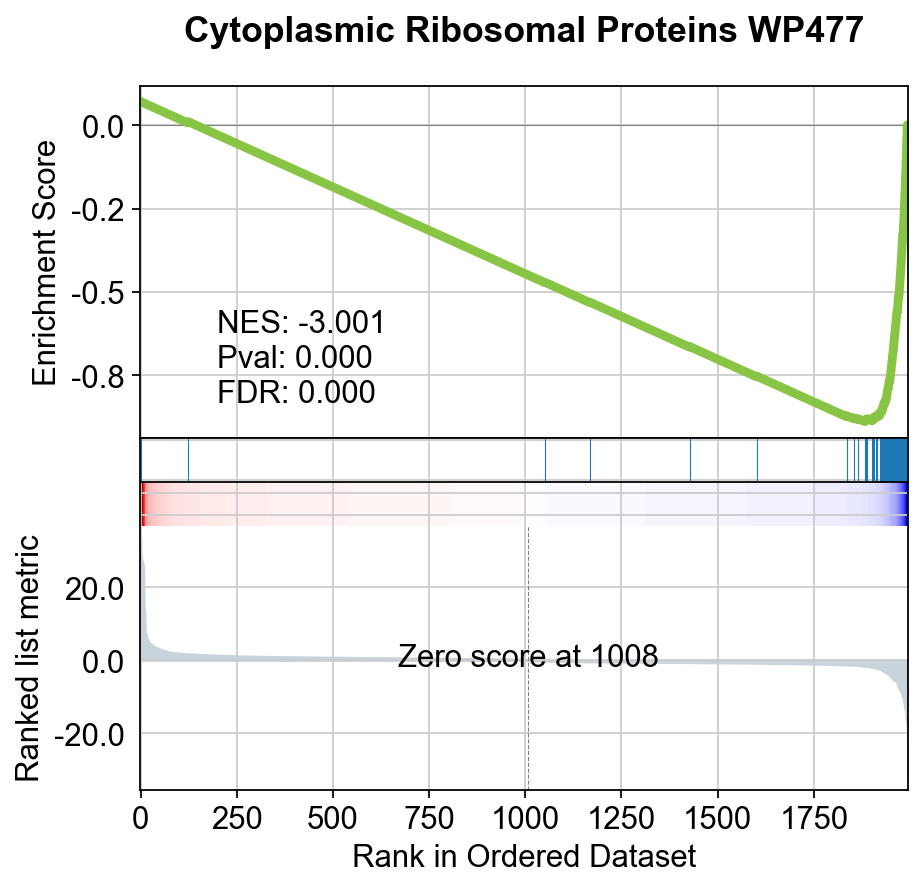

In [39]:
gseapy.gseaplot(rank_metric=res.ranking, term=terms[0], **res.results[terms[0]])

<style>
div.blue { background-color:#e6f0ff; border-radius: 5px; padding: 10px;}
</style>
<div class = "blue">
**Your turn**

Which KEGG pathways are upregulated in this cluster?
Which KEGG pathways are dowregulated in this cluster?
Change the pathway source to another gene set (e.g. "CP:WIKIPATHWAYS" or "CP:REACTOME" or "CP:BIOCARTA" or "GO:BP") and check the if you get simmilar results?
</div>

Finally, lets save the integrated data for further analysis.


In [40]:
adata.write_h5ad('./data/results/scanpy_DGE_covid.h5ad')